In [5]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [6]:
df = pd.read_csv('spam.csv', encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3483,ham,Tell my bad character which u Dnt lik in me. ...,NaN,NaN,NaN
2526,ham,Do u noe how 2 send files between 2 computers?,NaN,NaN,NaN
2267,ham,Finish liao... U?,NaN,NaN,NaN
2057,ham,"Nothing, i got msg frm tht unknown no..",NaN,NaN,NaN
5015,ham,Hey gals...U all wanna meet 4 dinner at nÌÂte?,NaN,NaN,NaN


In [8]:
df.shape

(5572, 5)

DATA CLEANING


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [10]:
# drop last 3 cols as they don't make enough sense

df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [11]:
#rename the columns
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
2741,spam,I don't know u and u don't know me. Send CHAT ...
2853,ham,Haha... Hope Ì_ can hear the receipt sound... ...
5000,ham,"Nope. Since ayo travelled, he has forgotten hi..."
718,spam,You have WON a guaranteed å£1000 cash or a å£2...
2391,ham,PICK UR FONE UP NOW U DUMB?


In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [13]:
df['target'] = encoder.fit_transform(df['target'])

In [14]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [16]:
#check for duplicated values
df.duplicated().sum()

np.int64(403)

In [17]:
#remove duplicated
df=df.drop_duplicates(keep='first')

In [18]:
df.duplicated().sum()

np.int64(0)

In [19]:
df.shape

(5169, 2)

DATA EXPLORATION


In [20]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

DATA IMBALANCE CHECK

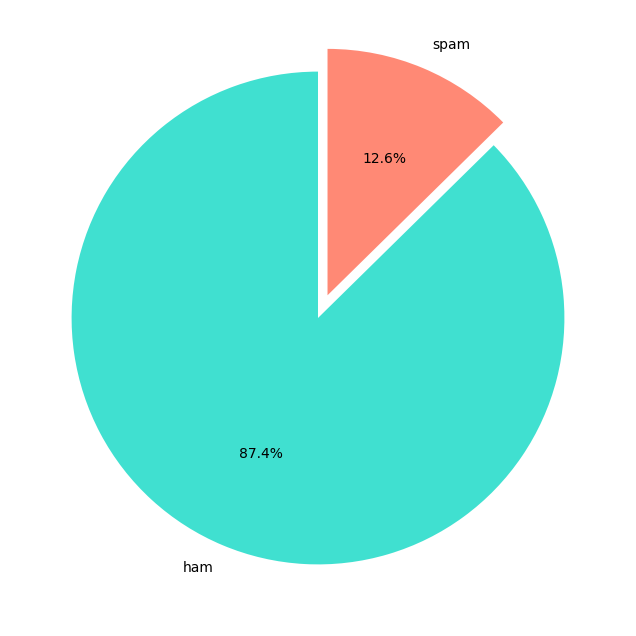

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct='%1.1f%%', colors = ['turquoise','#ff8975'], startangle=90, explode = (0, 0.1))
plt.show()

FEATURE ENGINEERING


In [23]:
import nltk
df['num_characters'] = df['text'].apply(len)

# num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

# num of sentences
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [24]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [25]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [26]:
import seaborn as sns

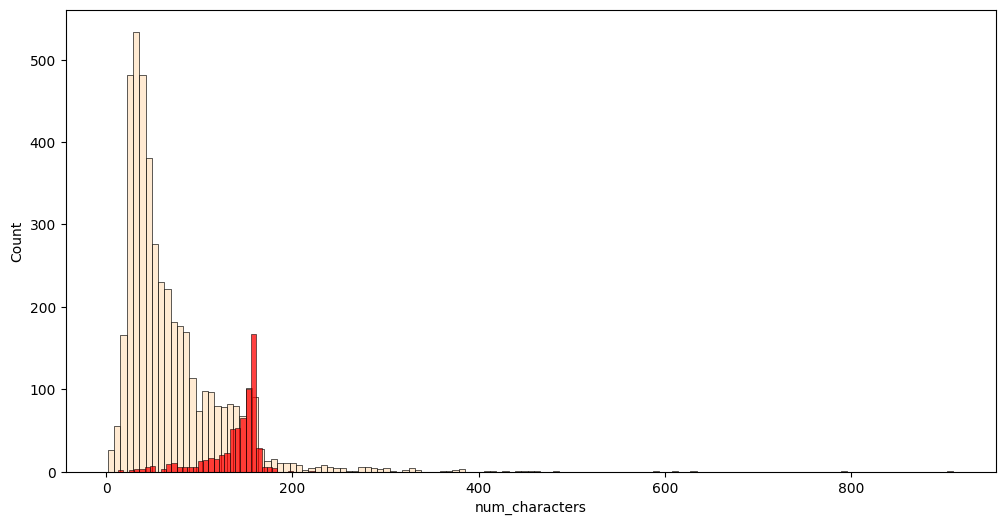

In [27]:
##distribution of spam and ham characters

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'], color = 'bisque')
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')
plt.show()

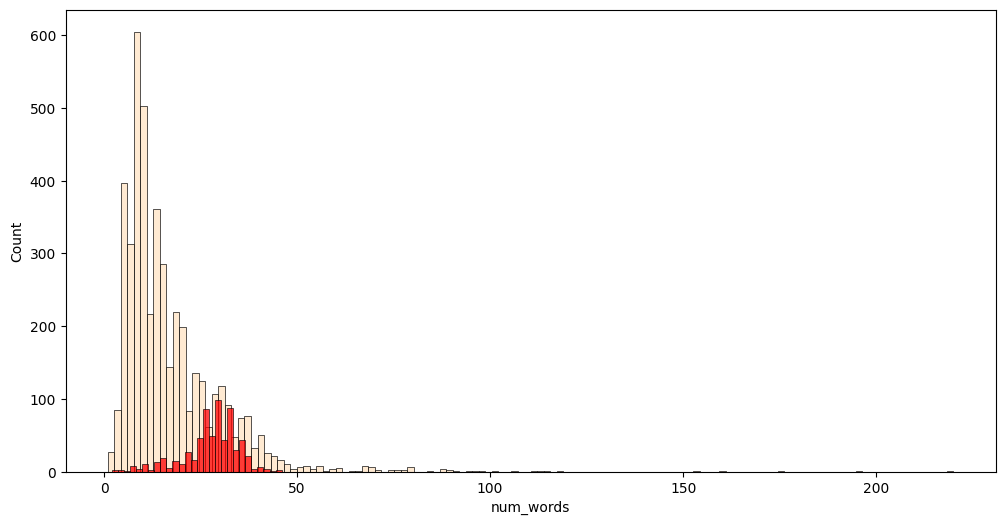

In [28]:
#distribution of spam and ham words

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'],color='bisque')
sns.histplot(df[df['target'] == 1]['num_words'],color='red')
plt.show()


Outlier Detection

<Figure size 1400x600 with 0 Axes>

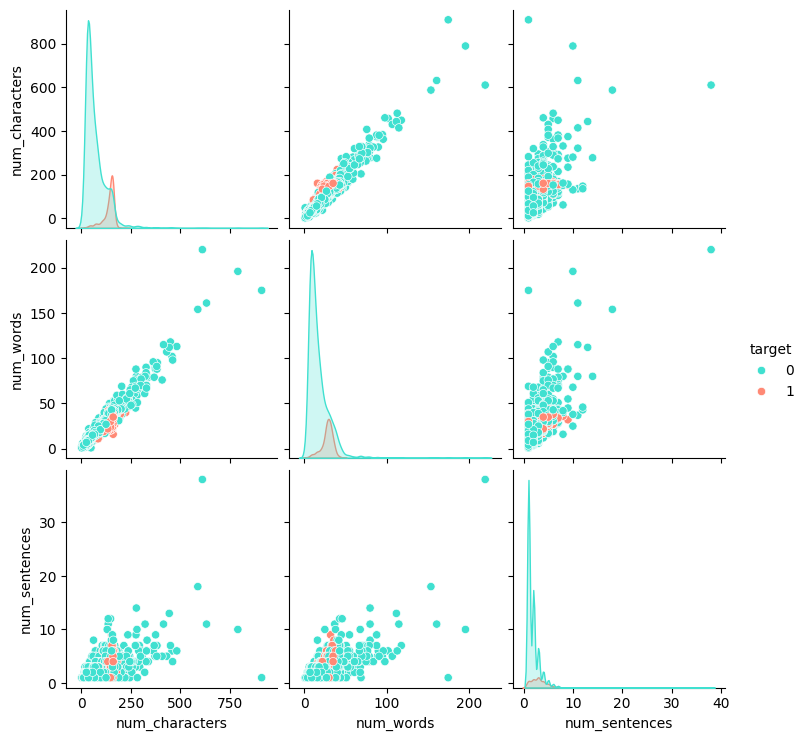

In [29]:
#pairplot
plt.figure(figsize=(14,6))
cols= ['turquoise','#ff8975'] 
sns.pairplot(df,hue='target',palette=cols)
plt.show()

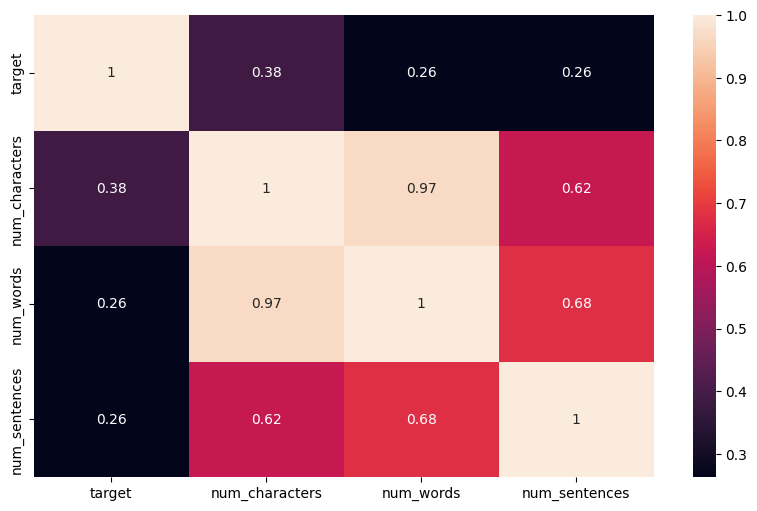

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True)
plt.show()

DATA PREPROCESSING

In [32]:
#lowercase, tokenization, special chars/punctualtion and stopwords removal

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
import string

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    #retaining only numbers and alphabets
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    #clone copy of list y
    text = y[:]
    y.clear()
    
    #stopwords removal
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation: y.append(i)
            
    text = y[:]
    y.clear()
    
    #stemming
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\DELL
[nltk_data]     5402\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [34]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [35]:
df['text'][10]


"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [36]:
#sample stemming result
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
ps.stem('loving')

'love'

In [37]:
df['transformed_text'] = df['text'].apply(transform_text)

In [38]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


View Frequent words in our data post text preprocessing


In [39]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [40]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

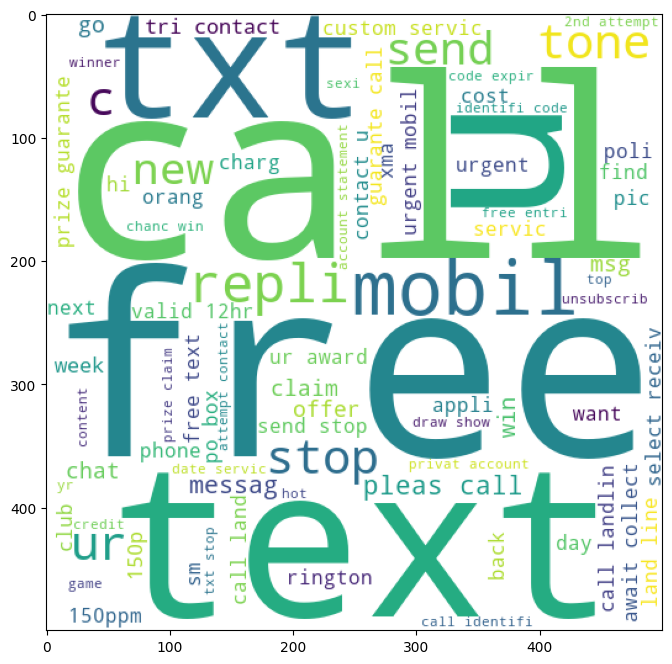

In [41]:
plt.figure(figsize=(20,8))
plt.imshow(spam_wc)
plt.show()

In [42]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

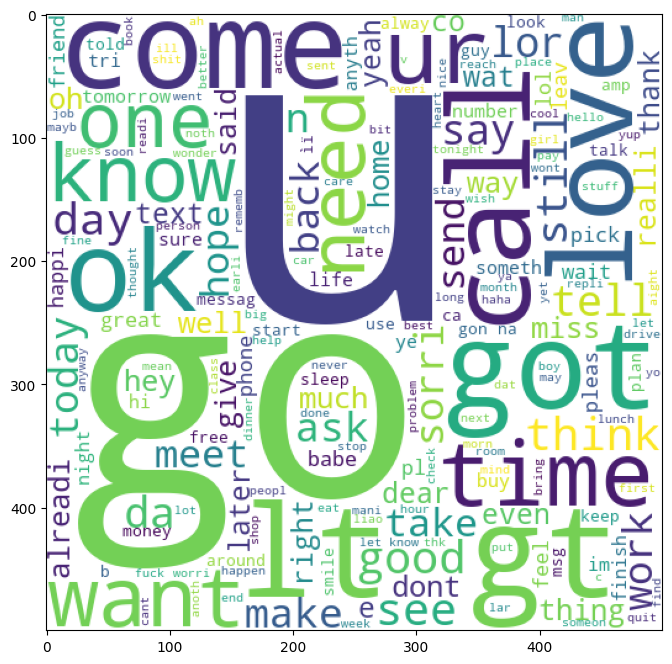

In [43]:
plt.figure(figsize=(20,8))
plt.imshow(ham_wc)
plt.show()

In [44]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [53]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [54]:
len(spam_corpus)

9939

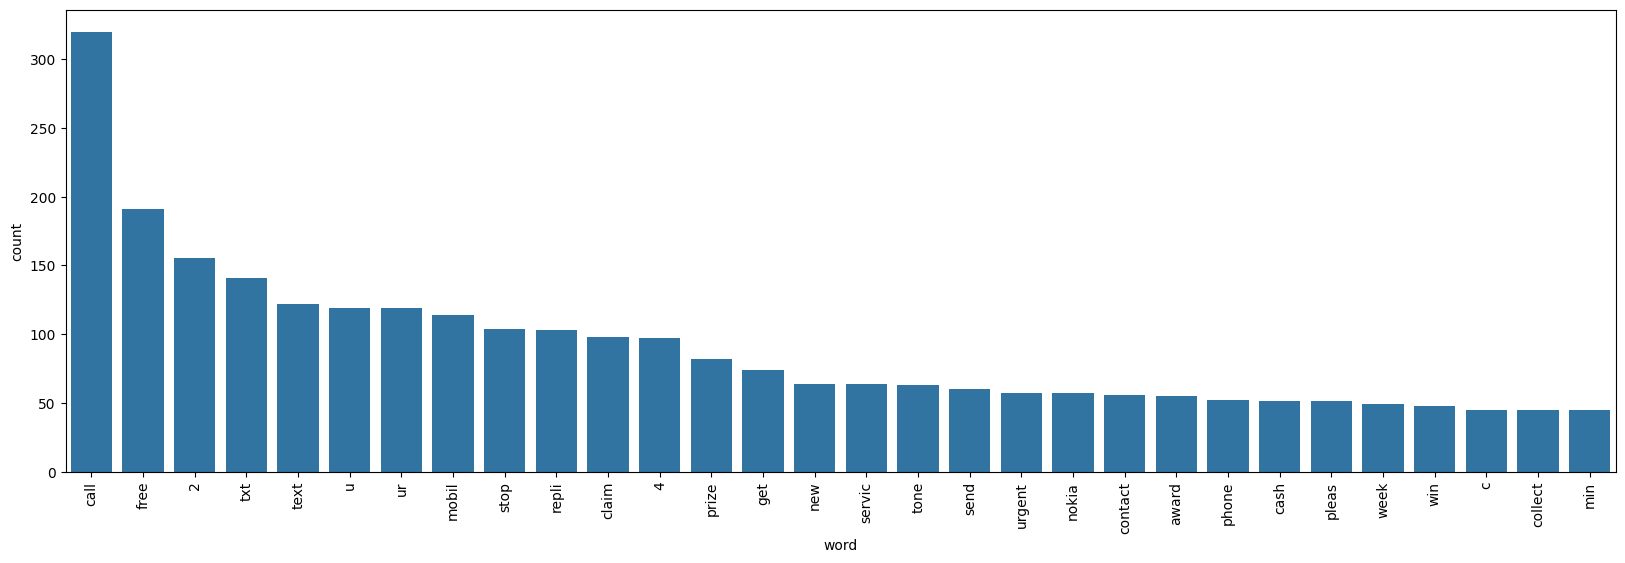

In [55]:
warnings.filterwarnings('ignore')

from collections import Counter

word_counts = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['word', 'count'])

plt.figure(figsize=(20,6))
sns.barplot(x='word', y='count', data=word_counts)
plt.xticks(rotation='vertical')
plt.show()


In [56]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [57]:
len(ham_corpus)

35404

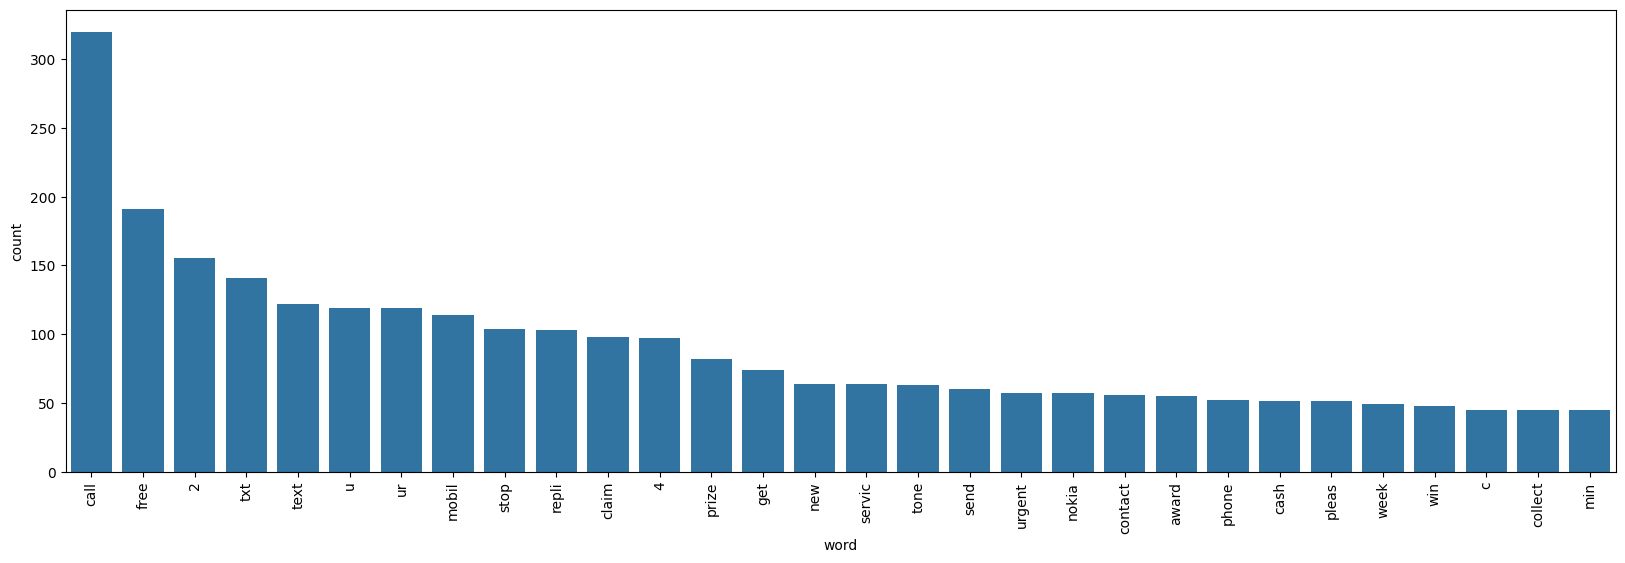

In [58]:

word_counts = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['word', 'count'])

plt.figure(figsize=(20,6))
sns.barplot(x='word', y='count', data=word_counts)
plt.xticks(rotation='vertical')
plt.show()

Vectorization

In [59]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()

##tfidf = TfidfVectorizer

#Setting max_features t0 3000 here after tring multiple random values this ones shows best results
tfidf = TfidfVectorizer(max_features=3000)


In [60]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [61]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


Model Building


In [62]:
X.shape

(5169, 3000)

In [63]:
y = df['target'].values

Train-test split

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

MODEL 1- NAIVE BAYES

In [66]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [67]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

GaussianNB


In [68]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8733075435203095
[[790 106]
 [ 25 113]]
0.5159817351598174


Multinomial NB

In [69]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


BernoulIi NB

In [70]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


Pipeline - OTHER MODELS

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [72]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc =  BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt =GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)


Model Evaluation

In [73]:
# DICTIONARY OF CLASSIFIERS

clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'XGB':xgb
}

In [74]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    #train_accuracy = accuracy_score(X_train, y_train)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    
    return accuracy,precision,f1,recall

In [75]:
#train_classifier(svc,X_train,y_train,X_test,y_test)
accuracy_scores = []
precision_scores = []
f1_scores = []
recall_scores = []

for name,clf in clfs.items():
    
    current_accuracy, current_precision, f1_score, recall_score = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("\nFor classifier ",name, ":")
    print("  Test_Accuracy - ",current_accuracy)
    print("  Precision - ", current_precision)
    print("  F1 Score - ", f1_score)
    print("  Recall - ",recall_score)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    f1_scores.append(f1_score)
    recall_scores.append(recall_score)


For classifier  SVC :
  Test_Accuracy -  0.9758220502901354
  Precision -  0.9747899159663865
  F1 Score -  0.9027237354085603
  Recall -  0.8405797101449275

For classifier  KN :
  Test_Accuracy -  0.9052224371373307
  Precision -  1.0
  F1 Score -  0.449438202247191
  Recall -  0.2898550724637681

For classifier  NB :
  Test_Accuracy -  0.9709864603481625
  Precision -  1.0
  F1 Score -  0.8780487804878049
  Recall -  0.782608695652174

For classifier  DT :
  Test_Accuracy -  0.9323017408123792
  Precision -  0.8333333333333334
  F1 Score -  0.7083333333333334
  Recall -  0.6159420289855072

For classifier  LR :
  Test_Accuracy -  0.9564796905222437
  Precision -  0.9696969696969697
  F1 Score -  0.810126582278481
  Recall -  0.6956521739130435

For classifier  RF :
  Test_Accuracy -  0.97678916827853
  Precision -  0.975
  F1 Score -  0.9069767441860465
  Recall -  0.8478260869565217

For classifier  AdaBoost :
  Test_Accuracy -  0.9235976789168279
  Precision -  0.8390804597701149

In [76]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Test_Accuracy':accuracy_scores,'Precision':precision_scores, 'Recall':recall_scores, 'F1_Score':f1_scores}).sort_values('Precision',ascending=False)

In [77]:
cmap2 = ListedColormap(['turquoise','#ff8975'])
performance_df.style.background_gradient(cmap=cmap2)


,Algorithm,Test_Accuracy,Precision,Recall,F1_Score
1,KN,0.905222,1.000000,0.289855,0.449438
2,NB,0.970986,1.000000,0.782609,0.878049
5,RF,0.976789,0.975000,0.847826,0.906977
0,SVC,0.975822,0.974790,0.840580,0.902724
4,LR,0.956480,0.969697,0.695652,0.810127
8,ETC,0.977756,0.967480,0.862319,0.911877
10,XGB,0.968085,0.933884,0.818841,0.872587
9,GBDT,0.950677,0.930693,0.681159,0.786611
7,BgC,0.959381,0.869231,0.818841,0.843284
6,AdaBoost,0.923598,0.839080,0.528986,0.648889


BEST PERFORMANCE AMOUNG ALL CONSIDERING PRECISION - NB and KN

In [78]:
performance_df

,Algorithm,Test_Accuracy,Precision,Recall,F1_Score
1,KN,0.905222,1.000000,0.289855,0.449438
2,NB,0.970986,1.000000,0.782609,0.878049
5,RF,0.976789,0.975000,0.847826,0.906977
0,SVC,0.975822,0.974790,0.840580,0.902724
4,LR,0.956480,0.969697,0.695652,0.810127
8,ETC,0.977756,0.967480,0.862319,0.911877
10,XGB,0.968085,0.933884,0.818841,0.872587
9,GBDT,0.950677,0.930693,0.681159,0.786611
7,BgC,0.959381,0.869231,0.818841,0.843284
6,AdaBoost,0.923598,0.839080,0.528986,0.648889


In [79]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [80]:
performance_df1

,Algorithm,variable,value
0,KN,Test_Accuracy,0.905222
1,NB,Test_Accuracy,0.970986
2,RF,Test_Accuracy,0.976789
3,SVC,Test_Accuracy,0.975822
4,LR,Test_Accuracy,0.956480
5,ETC,Test_Accuracy,0.977756
6,XGB,Test_Accuracy,0.968085
7,GBDT,Test_Accuracy,0.950677
8,BgC,Test_Accuracy,0.959381
9,AdaBoost,Test_Accuracy,0.923598


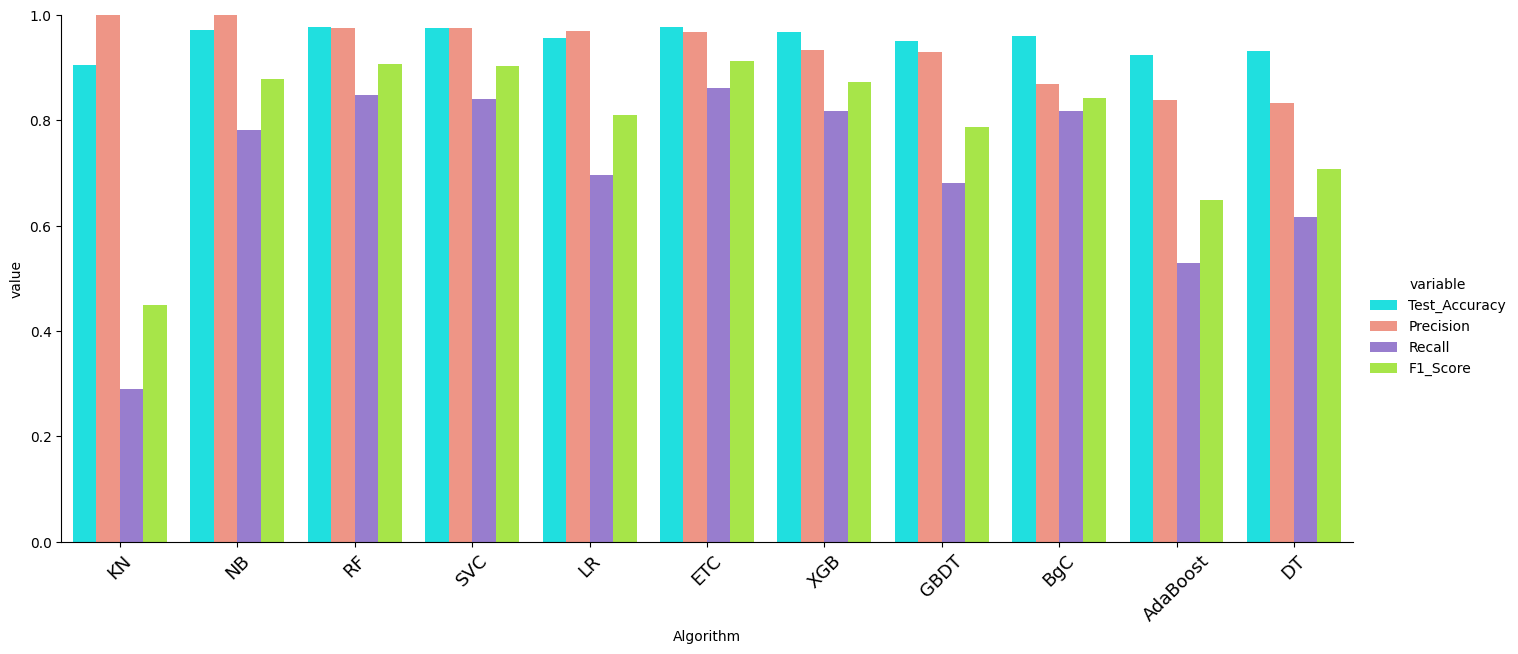

In [81]:
cols = cols= ['cyan','#ff8975', 'mediumpurple','greenyellow'] 
plt = sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=6, palette = cols, aspect=2.3)


plt.set(ylim=(0,1.0))
for axes in plt.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, size=13)

Model Improvement


In [83]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000',ascending=False)

In [84]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)

In [85]:
new_df = performance_df.merge(temp_df,on='Algorithm')

In [86]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# appending the num_character col to X
X = np.hstack((X,df['num_characters'].values.reshape(-1,1)))


In [87]:
new_df_scaled = new_df.merge(temp_df,on='Algorithm')

In [88]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)

In [89]:
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Test_Accuracy,Precision,Recall,F1_Score,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,KN,0.905222,1.000000,0.289855,0.449438,0.905222,1.000000,0.905222,1.000000,0.905222,1.000000
1,NB,0.970986,1.000000,0.782609,0.878049,0.970986,1.000000,0.970986,1.000000,0.970986,1.000000
2,RF,0.976789,0.975000,0.847826,0.906977,0.976789,0.975000,0.976789,0.975000,0.976789,0.975000
3,SVC,0.975822,0.974790,0.840580,0.902724,0.975822,0.974790,0.975822,0.974790,0.975822,0.974790
4,LR,0.956480,0.969697,0.695652,0.810127,0.956480,0.969697,0.956480,0.969697,0.956480,0.969697
5,ETC,0.977756,0.967480,0.862319,0.911877,0.977756,0.967480,0.977756,0.967480,0.977756,0.967480
6,XGB,0.968085,0.933884,0.818841,0.872587,0.968085,0.933884,0.968085,0.933884,0.968085,0.933884
7,GBDT,0.950677,0.930693,0.681159,0.786611,0.950677,0.930693,0.950677,0.930693,0.950677,0.930693
8,BgC,0.959381,0.869231,0.818841,0.843284,0.959381,0.869231,0.959381,0.869231,0.959381,0.869231
9,AdaBoost,0.923598,0.839080,0.528986,0.648889,0.923598,0.839080,0.923598,0.839080,0.923598,0.839080


In [90]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [91]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

In [92]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [93]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.9834710743801653


Try Stacking classifier with NB, SVM and ETC combination

In [94]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [95]:
from sklearn.ensemble import StackingClassifier

In [96]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [97]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.9465648854961832


Final Model